# Final Project Forecasting

Course: Predictive Modelling Analytics

Group Member:
- I Gusti Agung Jaya Hiswara (5026211122)
- Faqih
- Afaf
- Candeline


## Setup
### Initialize Global Variables

In [40]:
WINDOW_SIZE = 12 # 12 months (1 year)
FORECAST_WINDOW = 60 # 5 years
ARRIVAL = 'Kedatangan_Internasional'

### Import Libraries, Dependencides and Dataset

In [41]:
# Importing the libraries
# %pip install pmdarima tensorflow

import pandas as pd
from pandas import read_csv
from pandas import to_datetime

import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error 
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.metrics import MeanAbsolutePercentageError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, Dense

import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, YearLocator, MonthLocator

import statsmodels.api as sm
from pmdarima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing


# import warnings
# warnings.filterwarnings('ignore')

# Importing the dataset
data = read_csv("Dataset/Data_FP_PAP-C.csv")
data.head()

,Tahun,Bulan,Kedatangan_Internasional,Periode,Tanggal
0,2017,1,9394,1,01/01/2017
1,2017,2,8775,2,02/01/2017
2,2017,3,11305,3,03/01/2017
3,2017,4,13204,4,04/01/2017
4,2017,5,11792,5,05/01/2017


In [42]:
# Check NaN values
data.isnull().sum()

Tahun                       0
Bulan                       0
Kedatangan_Internasional    0
Periode                     0
Tanggal                     0
dtype: int64

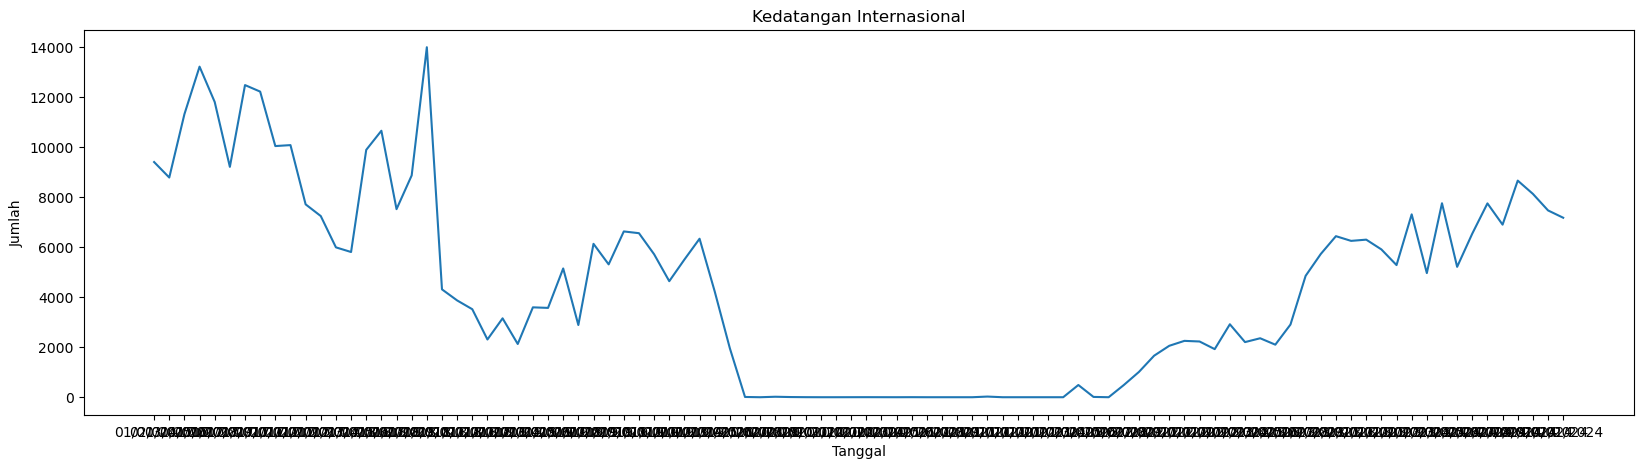

In [43]:
# Plot By Kedatangan Internasional
plt.figure(figsize=(20, 5))
plt.plot(data['Tanggal'], data[ARRIVAL])
plt.title('Kedatangan Internasional')
plt.xlabel('Tanggal')
plt.ylabel('Jumlah')
plt.show()

## Preprocessing
### Convert variables to the correct data type

In [44]:
data['Tanggal'] = to_datetime(data['Tanggal'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Tahun                     94 non-null     int64         
 1   Bulan                     94 non-null     int64         
 2   Kedatangan_Internasional  94 non-null     int64         
 3   Periode                   94 non-null     int64         
 4   Tanggal                   94 non-null     datetime64[ns]
dtypes: datetime64[ns](1), int64(4)
memory usage: 3.8 KB


In [45]:
scaler = MinMaxScaler()
data[ARRIVAL] = scaler.fit_transform(data[ARRIVAL].values.reshape(-1, 1))
data.head()

,Tahun,Bulan,Kedatangan_Internasional,Periode,Tanggal
0,2017,1,0.671960,1,2017-01-01
1,2017,2,0.627682,2,2017-02-01
2,2017,3,0.808655,3,2017-03-01
3,2017,4,0.944492,4,2017-04-01
4,2017,5,0.843491,5,2017-05-01


## Exploratory Data Analysis (EDA)
### Visualization

In [46]:
def visualize(data, var=[], label=''):
    fig, ax = plt.subplots(figsize=(25, 10))
    plt.title(f'Kedatangan Bandara Internasional Lombok {label}', fontsize=20)

    for v in var:
        plt.plot(data['Tanggal'], data[v], label=v)
    
    plt.xlim(data['Tanggal'].min(), data['Tanggal'].max())
    plt.xlabel('Date', fontsize=15)

    ax.xaxis.set_major_locator(YearLocator())
    ax.xaxis.set_minor_locator(MonthLocator((4,8,12)))

    ax.xaxis.set_major_formatter(DateFormatter("\n%Y"))
    ax.xaxis.set_minor_formatter(DateFormatter("%b"))
    plt.setp(ax.get_xticklabels(), rotation=0, ha="center")

    ax.get_yaxis().get_major_formatter().set_scientific(False)

    plt.legend()  
    plt.show()

In [47]:
def compare_pred_actual(results, title="Model Predictions vs Actuals"):
    """
    Compare predictions and actual values from different scenarios or models.
    """
    fig, ax = plt.subplots(figsize=(12, 8))
    fig.tight_layout(pad=5.0)

    # Plot predictions and actuals for ARRIVAL
    for scenario, result in results.items():
        ax.plot(result['Predictions'], label=f'{scenario} Predictions', linestyle='--')
        ax.plot(result['Actuals'], label=f'{scenario} Actuals', alpha=0.7)

    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Values', fontsize=12)
    ax.get_yaxis().get_major_formatter().set_scientific(False)
    ax.legend(loc='best')
    plt.show()



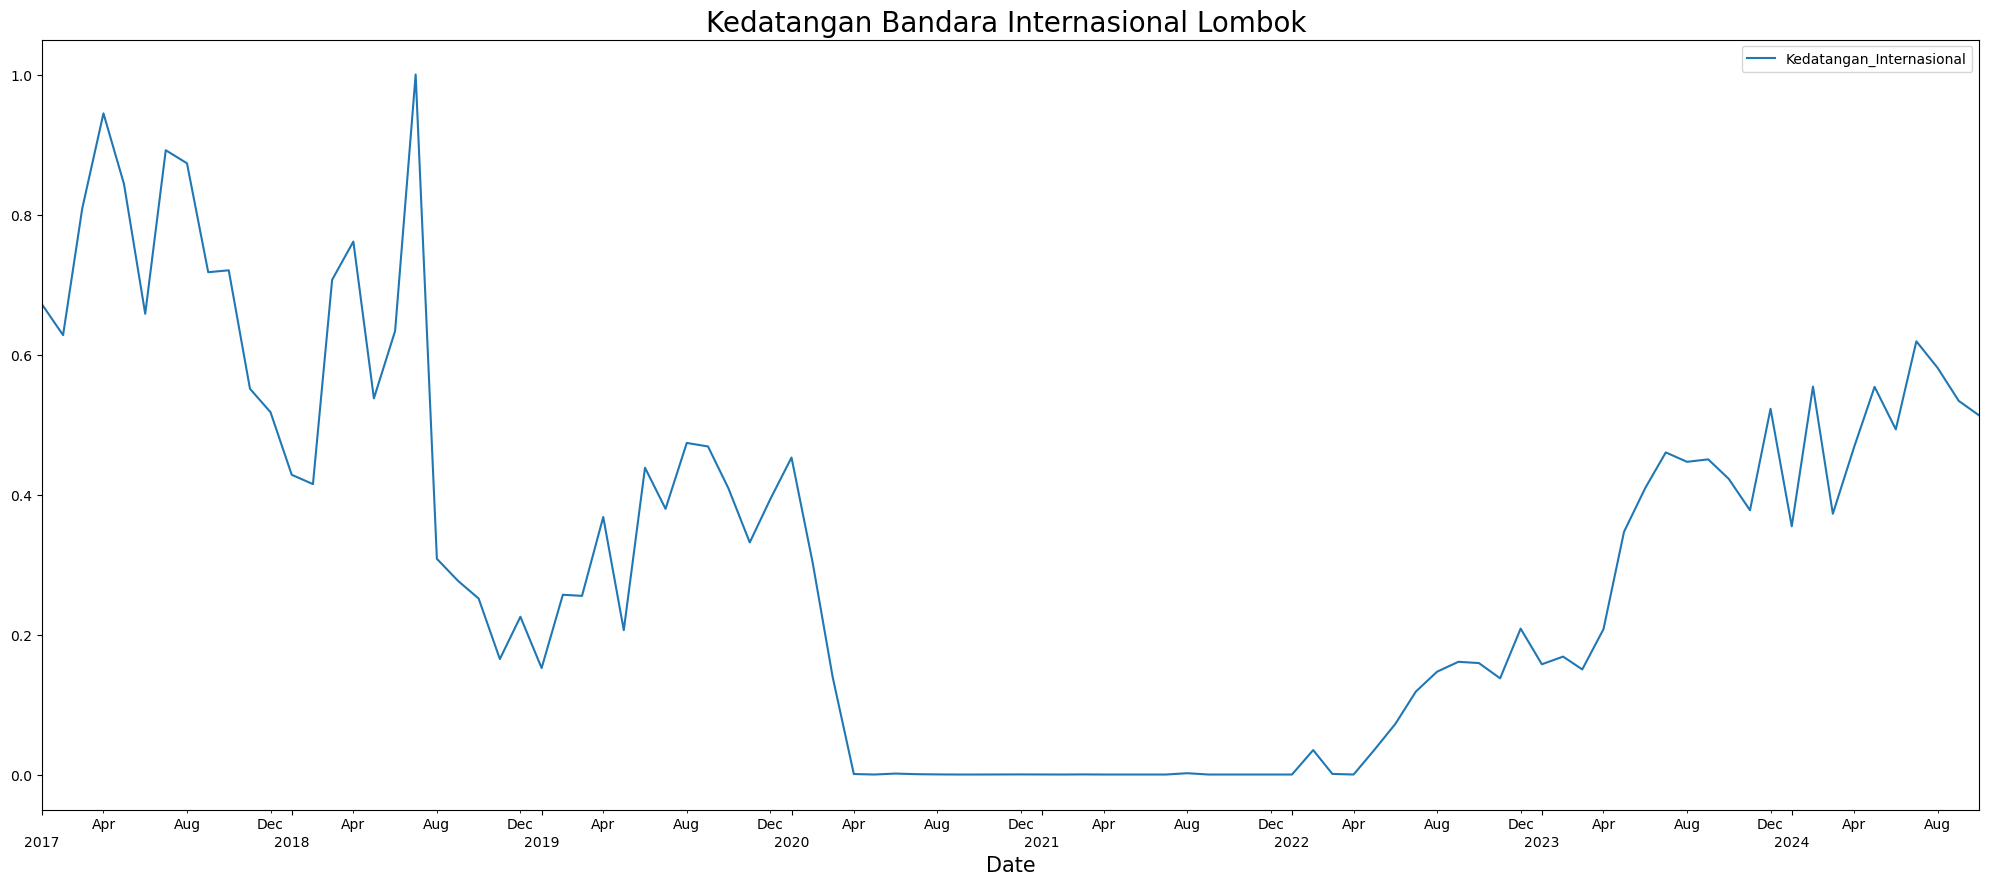

In [48]:
visualize(data, [ARRIVAL])

## Modeling
### Data Windows

In [49]:
def dataframe_to_windowed_data(df, window_size):
  df_as_np = df.to_numpy()
  x = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    x.append(row)
    label = df_as_np[i+window_size]

    y.append(label)
  return np.array(x), np.array(y)

### Building Models
#### Prophet


#### SARIMA

In [50]:
def create_SARIMA(train_data, seasonal_period):
    """
    Create a SARIMA model using auto_arima.
    """
    model_SARIMA = auto_arima(
        train_data,
        start_p=0, start_q=0, start_P=0, start_Q=0,
        d=None, seasonal=True, m=seasonal_period,
        trace=True, error_action='warn', suppress_warnings=True,
        stepwise=True, random_state=20, n_fits=50
    )
    return model_SARIMA

def train_SARIMA(train_ratio=0.8) -> dict:
    """
    Train the SARIMA model and return predictions for training and testing data.
    """
    results = {}

    # Split the data into training and testing sets
    train, test = train_test_split(data, train_size=train_ratio, shuffle=False)

    # Perform differencing to make the data stationary
    d_val = 0
    train_copy = train[ARRIVAL].copy()
    while adfuller(train_copy)[1] > .05:
        print('Performing differencing on data')
        train_copy = train_copy.diff().dropna()
        d_val += 1

    # Create and fit the SARIMA model
    model_SARIMA = create_SARIMA(train[ARRIVAL], seasonal_period)

    # Generate predictions
    predictions_SARIMA = model_SARIMA.predict(n_periods=len(test))
    predictions_SARIMA = pd.Series(
        list(train[ARRIVAL]) + list(predictions_SARIMA),
        index=data['Periode']
    )

    # Prepare test series for evaluation
    pad = [None] * len(train[ARRIVAL])
    test_series = pd.Series(pad + list(test[ARRIVAL]), index=data['Periode'])

    # Save the results
    results[ARRIVAL] = pd.DataFrame(
        data={'Predictions': predictions_SARIMA, 'Actuals': test_series}
    )

    return results

def forecast_SARIMA(forecast_window, seasonal_period=12):
    """
    Forecast future values using the SARIMA model.
    """
    results = {}

    # Perform differencing to make the data stationary
    d_val = 0
    train_copy = data[ARRIVAL].copy()
    while adfuller(train_copy)[1] > .05:
        print('Performing differencing on data')
        train_copy = train_copy.diff().dropna()
        d_val += 1

    # Create and fit the SARIMA model
    model = create_SARIMA(data[ARRIVAL], seasonal_period)

    # Generate future forecasts
    pred = pd.Series(
        list(model.predict(n_periods=forecast_window)),
        index=index_forecast
    )
    pred = round(pred, 2)

    # Save the forecast
    results[ARRIVAL] = pred

    return results


#### LSTM

In [51]:
def create_LSTM() -> Sequential:
    model_LSTM = Sequential()
    model_LSTM.add(LSTM(64, activation='relu', input_shape=(WINDOW_SIZE, 1), return_sequences=True))
    model_LSTM.add(Dropout(0.2))
    model_LSTM.add(LSTM(64, activation='relu'))
    model_LSTM.add(Dropout(0.2))
    model_LSTM.add(Dense(8, activation='relu'))
    model_LSTM.add(Dense(1, activation='linear'))
    model_LSTM.compile(optimizer='adam', loss='mse')
    return model_LSTM

def train_LSTM(train_ratio=0.8) -> dict:
    train_res = {}
    test_res = {}

    x, y = dataframe_to_windowed_data(data[ARRIVAL], WINDOW_SIZE)
    range_index_train = int(train_ratio * len(x))

    x_train, y_train = x[:range_index_train], y[:range_index_train]
    x_test, y_test = x[range_index_train:], y[range_index_train:]

    model_LSTM = create_LSTM()
    model_LSTM.fit(x_train, y_train, epochs=100, batch_size=2)

    train_predictions = model_LSTM.predict(x_train).flatten()
    train_results = pd.DataFrame(data={'Predictions': train_predictions, 'Actuals': y_train})
    train_res[ARRIVAL] = train_results

    predictions_LSTM = model_LSTM.predict(x_test).flatten()
    test_results = pd.DataFrame(data={'Predictions': predictions_LSTM, 'Actuals': y_test})
    test_res[ARRIVAL] = test_results

    return train_res, test_res

def forecast_LSTM(forecast_window):
    results = {}

    model = create_LSTM()
    x, y = dataframe_to_windowed_data(data[ARRIVAL], WINDOW_SIZE)
    model.fit(x, y, epochs=100, batch_size=2)
    
    forecast = []
    current_input = y[-WINDOW_SIZE:].reshape((1, WINDOW_SIZE, 1))
    
    for _ in range(forecast_window):
        next_pred = model.predict(current_input)[0, 0]
        forecast.append(next_pred)
        current_input = np.append(current_input[:, 1:, :], [[[next_pred]]], axis=1)
    
    forecast = pd.Series(forecast, index=index_forecast)
    results[ARRIVAL] = forecast
    
    return results


#### HYBRID (SARIMA-LSTM)

In [52]:
data['Kedatangan_Internasional']

0     0.671960
1     0.627682
2     0.808655
3     0.944492
4     0.843491
        ...   
89    0.493062
90    0.618884
91    0.580973
92    0.533691
93    0.512804
Name: Kedatangan_Internasional, Length: 94, dtype: float64

In [53]:
import pmdarima as pmd

def evaluate_model(actual, predicted):
    """
    Evaluate the model using MSE, MAPE, MAE, and R² metrics.
    """
    mse = mean_squared_error(actual, predicted)
    mae = mean_absolute_error(actual, predicted)
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100  # Avoid division by zero
    r2 = r2_score(actual, predicted)
    return mse, mae, mape, r2

def train_and_evaluate_SARIMA(train_ratio, seasonal_period):
    """
    Train and evaluate the SARIMA model with a given train-test split ratio.
    """
    results = {}

    # Split the data into training and testing sets
    train, test = train_test_split(data, train_size=train_ratio, shuffle=False)

    # Create and fit the SARIMA model
    model_SARIMA = create_SARIMA(train[ARRIVAL], seasonal_period)

    # Generate predictions
    predictions_SARIMA = model_SARIMA.predict(n_periods=len(test))
    predictions_SARIMA = pd.Series(
        list(train[ARRIVAL]) + list(predictions_SARIMA),
        index=data['Tanggal']
    )

    # Prepare test series for evaluation
    pad = [None] * len(train[ARRIVAL])
    test_series = pd.Series(pad + list(test[ARRIVAL]), index=data['Tanggal'])

    # Evaluate the model
    mse, mae, mape, r2 = evaluate_model(test[ARRIVAL], predictions_SARIMA[len(train):])
    results[ARRIVAL] = {
        'Predictions': predictions_SARIMA,
        'Actuals': data[ARRIVAL],
        'MSE': mse,
        'MAE': mae,
        'MAPE': mape,
        'R²': r2
    }

    return results

## Evaluation, Training and Testing

1. 80% Train - 20% Test
2. 70% Train - 30 % Test
3. 60% Train - 40 % Test


### Prophet

### SARIMA

In [54]:
# Scenario 1: 80% Train - 20% Test
results_80 = train_and_evaluate_SARIMA(0.8, WINDOW_SIZE)

# Scenario 2: 70% Train - 30% Test
results_70 = train_and_evaluate_SARIMA(0.7, WINDOW_SIZE)

# # Scenario 3: 60% Train - 40% Test
results_60 = train_and_evaluate_SARIMA(0.6, WINDOW_SIZE)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-90.532, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-92.144, Time=0.03 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-94.393, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-92.307, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=-94.963, Time=0.01 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-94.218, Time=0.03 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=-92.561, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=-94.028, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[12] intercept   : AIC=-94.087, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-92.748, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[12]             : AIC=-96.413, Time=0.01 sec
 ARIMA(0,1,1)(1,0,0)[12]             : AIC=-95.796, Time=0.05 sec
 ARIMA(0,1,1)(0,0,1)[12]             : AIC=-95.972, Time=0.03 sec
 ARIMA(0,1,1)(1,0,1)[12]             

/var/folders/ft/5yvhz_g95kq24x3zxwvjp1t80000gn/T/ipykernel_28679/6839392.py:9: RuntimeWarning: '<' not supported between instances of 'Timestamp' and 'int', sort order is undefined for incomparable objects.
  mape = np.mean(np.abs((actual - predicted) / actual)) * 100  # Avoid division by zero


 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=-70.564, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[12] intercept   : AIC=-72.784, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-71.103, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[12]             : AIC=-74.414, Time=0.01 sec
 ARIMA(0,1,1)(1,0,0)[12]             : AIC=-73.597, Time=0.03 sec
 ARIMA(0,1,1)(0,0,1)[12]             : AIC=-73.732, Time=0.04 sec
 ARIMA(0,1,1)(1,0,1)[12]             : AIC=-71.809, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[12]             : AIC=-72.797, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[12]             : AIC=-73.260, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=-72.554, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[12]             : AIC=inf, Time=0.06 sec

Best model:  ARIMA(0,1,1)(0,0,0)[12]          
Total fit time: 0.721 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercep

/var/folders/ft/5yvhz_g95kq24x3zxwvjp1t80000gn/T/ipykernel_28679/6839392.py:9: RuntimeWarning: '<' not supported between instances of 'Timestamp' and 'int', sort order is undefined for incomparable objects.
  mape = np.mean(np.abs((actual - predicted) / actual)) * 100  # Avoid division by zero


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-51.139, Time=0.08 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-53.065, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-52.537, Time=0.00 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=-54.173, Time=0.01 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-52.970, Time=0.04 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=-51.129, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[12] intercept   : AIC=-53.653, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-52.199, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[12]             : AIC=-55.178, Time=0.01 sec
 ARIMA(0,1,1)(1,0,0)[12]             : AIC=-54.167, Time=0.02 sec
 ARIMA(0,1,1)(0,0,1)[12]             : AIC=-54.280, Time=0.02 sec
 ARIMA(0,1,1)(1,0,1)[12]             : AIC=-52.353, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[12]             : AIC=-53.506, Time=0.02 sec
 ARIMA(0,1,2)(0,0,

/var/folders/ft/5yvhz_g95kq24x3zxwvjp1t80000gn/T/ipykernel_28679/6839392.py:9: RuntimeWarning: '<' not supported between instances of 'Timestamp' and 'int', sort order is undefined for incomparable objects.
  mape = np.mean(np.abs((actual - predicted) / actual)) * 100  # Avoid division by zero


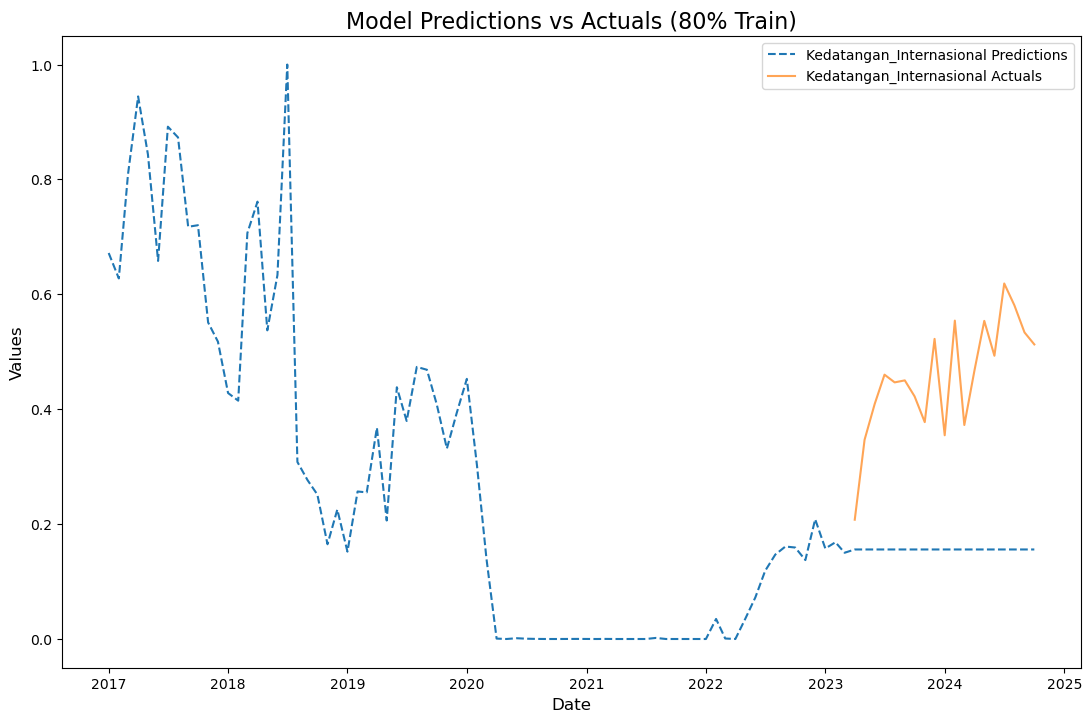

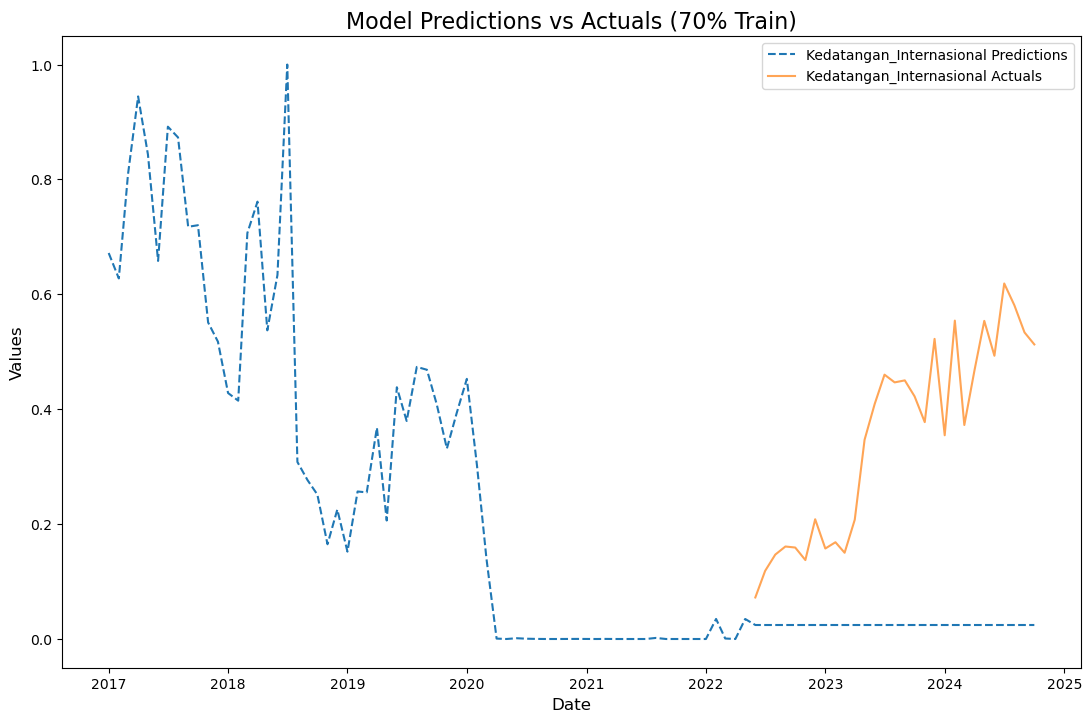

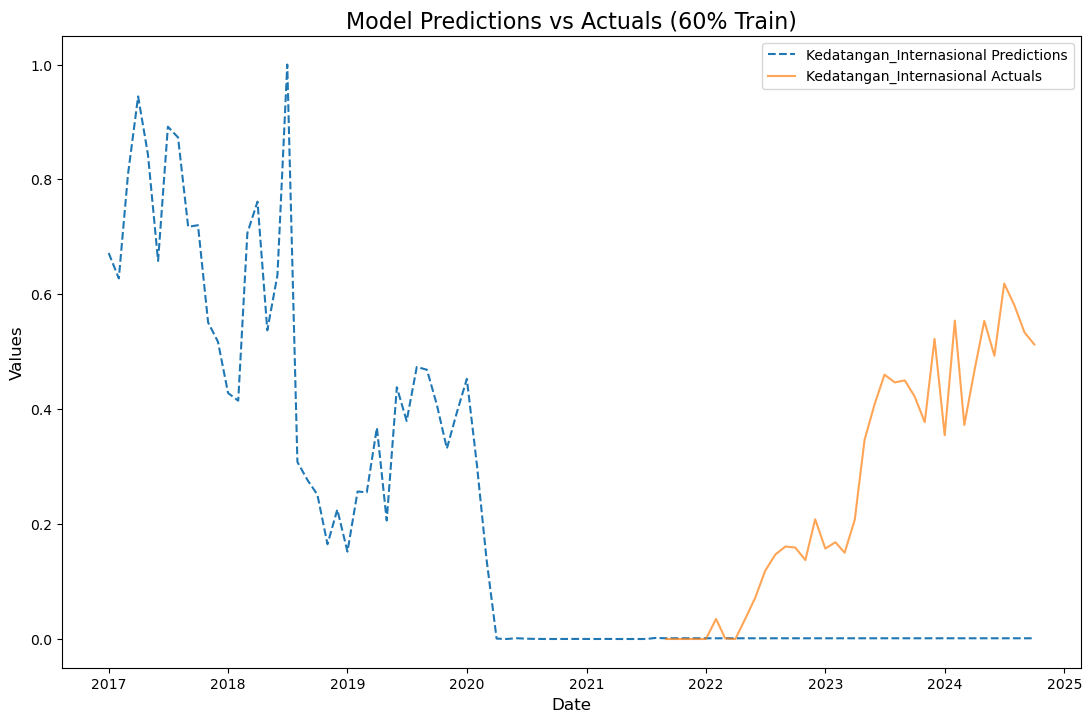

In [55]:
# Plot
compare_pred_actual(results_80, title="Model Predictions vs Actuals (80% Train)")
compare_pred_actual(results_70, title="Model Predictions vs Actuals (70% Train)")
compare_pred_actual(results_60, title="Model Predictions vs Actuals (60% Train)")


### LSTM

Epoch 1/100


/Users/ajhiswara/.local/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0847
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0375    
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0262
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0299
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0284
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0364
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0428
Epoch 8/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0354
Epoch 9/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0241
Epoch 10/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0216
Epoch 11/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0238
Epoch 12/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0223
Epoch 13/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0155
Epoch 14/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0268
Epoch 15/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0256
Epoch 16/100

KeyError: 'ARRIVAL'

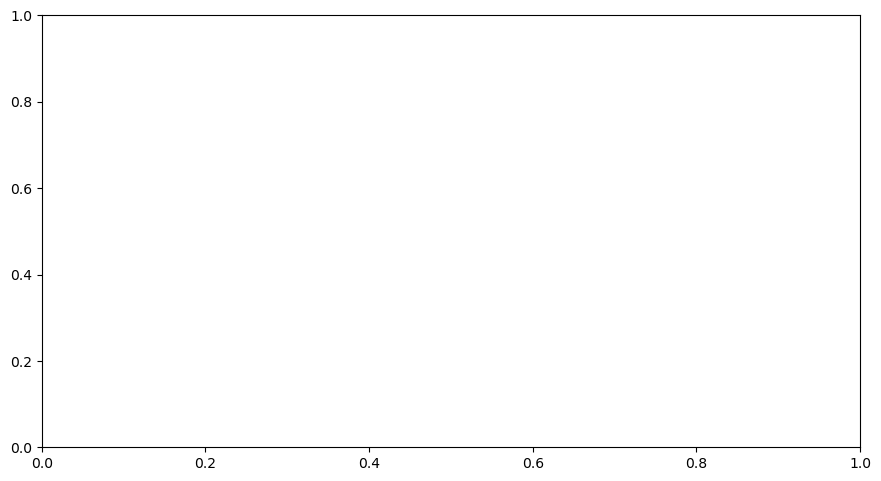

In [ ]:
LSTM_train_results, LSTM_test_results = train_LSTM(0.8)
compare_pred_actual(LSTM_train_results)

### HYBRID (SARIMA-LSTM)

In [ ]:
# Assuming LSTM_test_results is obtained from training the LSTM model
# Define LSTM_test_results here or in a previous cell

# Example: LSTM_test_results = train_LSTM_model()

SARIMA_LSTM_df = create_SARIMA_LSTM(
    SARIMA=results[ARRIVAL]['Predictions'],
    LSTM=LSTM_test_results[ARRIVAL]['Predictions']
)
result, LSTM_w, SARIMA_w = train_SARIMA_LSTM(SARIMA_LSTM_df)

KeyError: 0

## Evaluation

### Prophet

### SARIMA

In [ ]:
all_results = {
    "80% Train": results_80[ARRIVAL],
    "70% Train": results_70[ARRIVAL],
    "60% Train": results_60[ARRIVAL]
}

compare_pred_actual(all_results, title="SARIMA Predictions vs Actuals Across Scenarios")


### LSTM

### HYBRID (SARIMA-LSTM)

## Implementation


### Combine Historical and Forecast Data

In [ ]:
def combine_data(region, forecast, data):
    historical = data[['Tanggal', region]].copy()
    historical.columns = ['Tanggal', 'Historical']
    forecast.columns = ['Tanggal', 'Forecast']
    combined = pd.merge(historical, forecast, on='Tanggal', how='outer')
    return combined

### Exponential Smoothing (ETS)

### SARIMA

In [ ]:
forecasts = forecast_SARIMA(forecast_window)

# Combine historical and forecast data
historical_data = data[['Tanggal', ARRIVAL]].copy()
historical_data.columns = ['Tanggal', 'Historical']
forecast_data = pd.DataFrame({
    'Tanggal': index_forecast[:forecast_window],
    'Forecast': forecasts[ARRIVAL]
})

combined_data = pd.merge(historical_data, forecast_data, on='Tanggal', how='outer')
print(combined_data)


Performing differencing on data
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1704.185, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1702.434, Time=0.26 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1702.333, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1702.458, Time=0.00 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=1701.572, Time=0.01 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=1702.668, Time=0.04 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=1703.965, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=1703.883, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[12] intercept   : AIC=1703.899, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=1701.774, Time=0.00 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[12]             : AIC=1699.894, Time=0.01 sec
 ARIMA(0,1,1)(1,0,0)[12]             : AIC=1700.617, Time=0.03 sec
 ARIMA(0,1,1)(0,0,1)[12]             : AIC=1700.462, Time=0

ValueError: Length of values (12) does not match length of index (60)

#### LSTM

### Hybrid (SARIMA-LSTM)